In [1]:
from PIL import Image 
import cv2
import numpy as np
import matplotlib.pyplot as plt

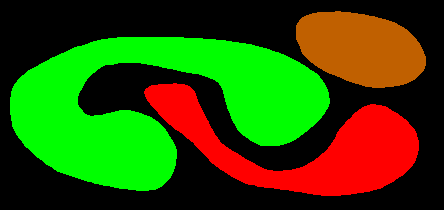

In [71]:
imgfile = './cc_sample_img.png'

img = Image.open(imgfile)

img

In [72]:
# grayscale
img = img.convert('L')

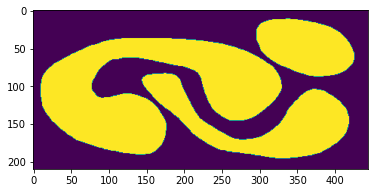

In [78]:
# binarization
thresh_value = 30
_, bin_img = cv2.threshold(np.array(img), thresh_value, 255, cv2.THRESH_BINARY)
bin_img = bin_img / 255.
plt.imshow(bin_img)

In [79]:
# object들은 255값, 배경은 0
print(np.unique(bin_img))

[0. 1.]


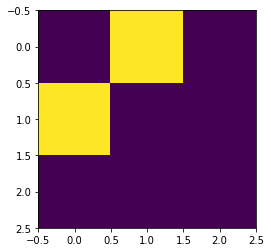

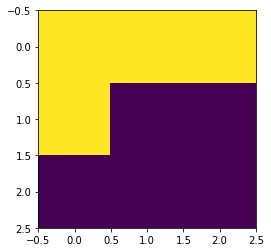

In [80]:
# 이미지에 slide할 filter
# 3x3 영역 내에 0이 아닌 값을 갖는 픽셀들끼리 연결시킨다.
connectivity_4 = np.array([[0,1,0],
                           [1,0,0],
                           [0,0,0]])
connectivity_8 = np.array([[1,1,1],
                           [1,0,0],
                           [0,0,0]])
plt.show()
plt.imshow(connectivity_4)
plt.show()
plt.imshow(connectivity_8)

In [81]:
def find_labels(labels, r, c, neighbors) :
    tmp_labels = labels[r-1:r+2, c-1:c+2] * neighbors
    return np.sort(tmp_labels[np.nonzero(tmp_labels)])

def connected_component_labelling(bin_img, connectivity=connectivity_8) :
    
    equivalent = [] # equivalent는 윈도우 안에 동시에 존재하는 label들이 같은 label임을 나타낸다. e.g) 2->1, 8->7, 항상 낮은값으로 병합
    labels = np.zeros_like(bin_img, dtype='int64')
    next_label = 1
    
    # 1st pass
    # connectivity 3x3의 윈도우를 슬라이드한다.
    for r, row in enumerate(bin_img) :
        for c, pixel in enumerate(row) :
            if pixel != 0 :
                try :
                    neighbors = bin_img[r-1:r+2, c-1:c+2]*connectivity # connectivity의 1위치 제외하고 나머지 값들은 0을 갖음. [r-1:r+2, c-1:c+2]의 shape이 connectivity shape과 다를 경우에 대한 예외처리가 필요함
                except :
                    pass
                num_neighbors = np.count_nonzero(neighbors) # 주변값들 중 0이 아닌 값이 있는지 확인
                
                if num_neighbors == 0 : # 주변값들이 전부 0일 경우, (r,c) 위치에 label을 마킹하고, equivalent에 같은 next_label 두 개를 넣는다.
                    labels[r,c] = next_label
                    equivalent.append([next_label, next_label])
                    next_label += 1
                else :
                    L = find_labels(labels, r, c, neighbors) # 윈도우 안에 동시에 존재하는 label들을 찾는다. np.sort하는 이유는 모르겠음.
                    labels[r,c] = np.min(L) # 낮은 값으로 라벨 병합
                    
                    uni_L = np.unique(L)
                    if len(uni_L) > 1 :
                        for i, e in enumerate(equivalent) :
                            if uni_L[0] in e :
                                equivalent[i].extend(uni_L[1:])
                                equivalent[i] = list(sorted(set(equivalent[i])))
    # 2nd pass. 다른 라벨들 통합                 
    for e in equivalent :
        for f in reversed(e) : # 뒤에서부터 확인해야 더 높은 라벨을 더 낮은 라벨로 치환할 수 있다. e.g) 2->1
            labels[labels==f] = e[0]
            
    return labels

def threshold_labels(labels, threshold = 100000) :
    
    unique_elements, counts_elements = np.unique(labels, return_counts = True)
    thr_elements = unique_elements[counts_elements> threshold]
    
    thr_labels = np.zeros_like(labels)
    
    cnt = 0
    for e in thr_elements :
        if e != 0 :
            cnt += 1
            thr_labels[labels == e] = cnt
    return thr_labels

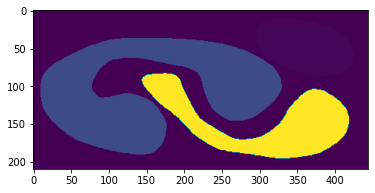

In [82]:
labels_4 = connected_component_labelling(bin_img, connectivity_4)
thr_labels_4 = threshold_labels(labels_4)

plt.imshow(labels_4)
